In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as tF
import torchmetrics.functional as tmF
from torch import nn
from sklearn.metrics import pairwise_distances

/opt/homebrew/anaconda3/envs/segmenting-subsurface-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
volume_path = os.path.join(os.pardir, 'data', 'raw', 'train', '69764103', 'horizon_labels_block-2_vol_69764103.npy')
volume = np.load(volume_path, allow_pickle=True)
volume = volume + 8
slice = volume[0, :, :].T
slice = torch.from_numpy(slice).to(dtype=torch.int64)

num_classes = 20

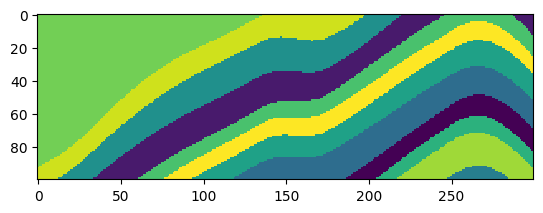

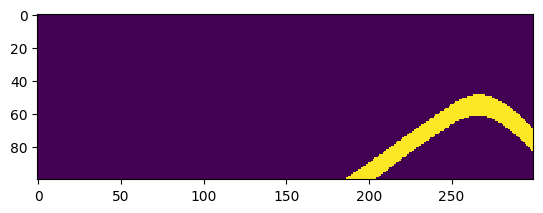

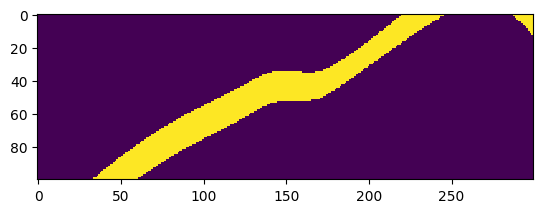

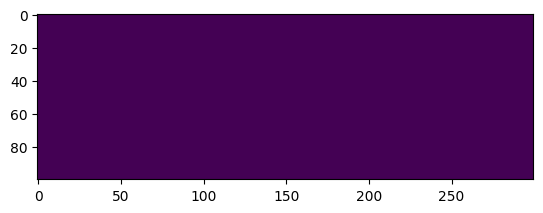

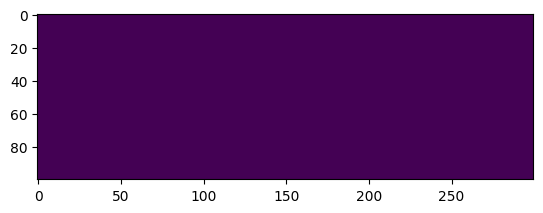

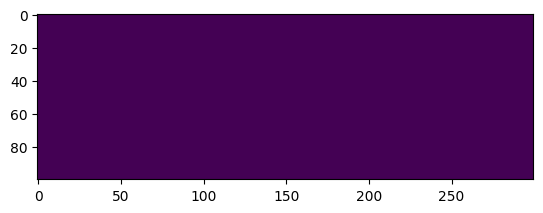

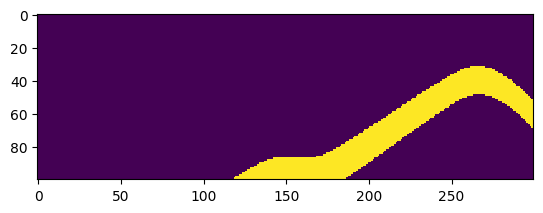

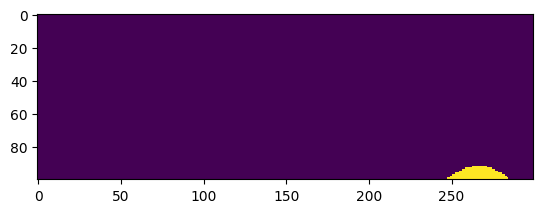

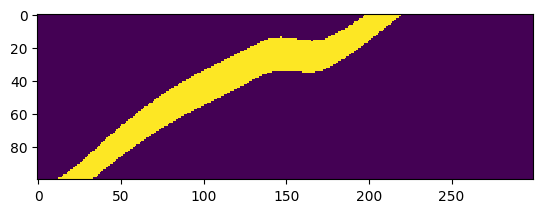

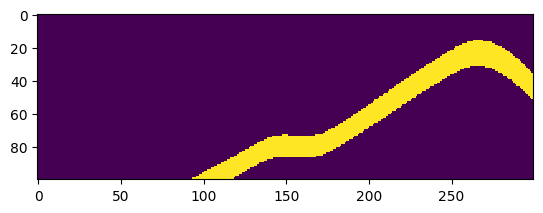

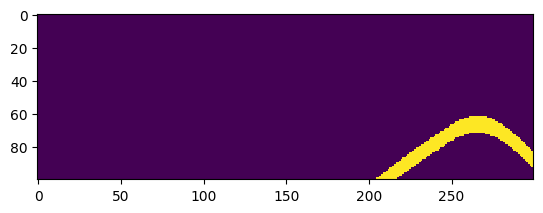

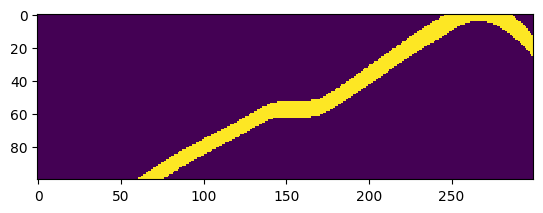

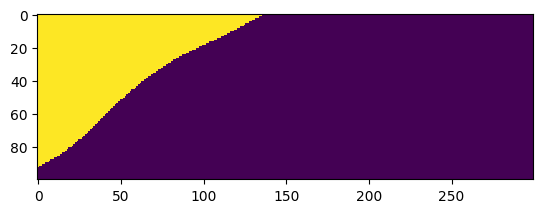

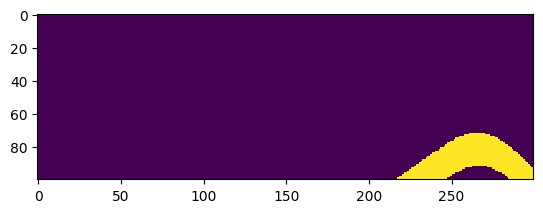

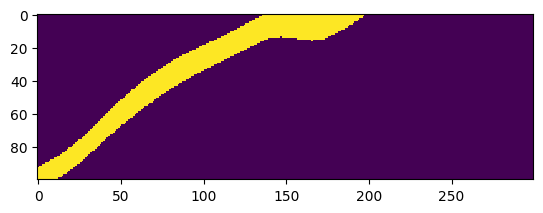

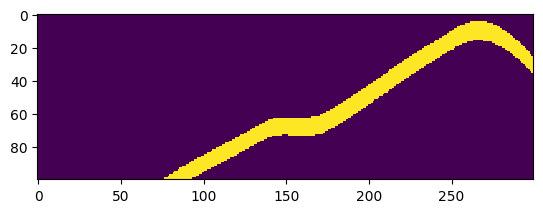

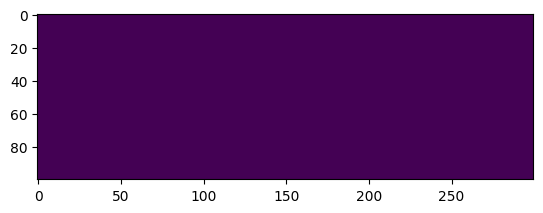

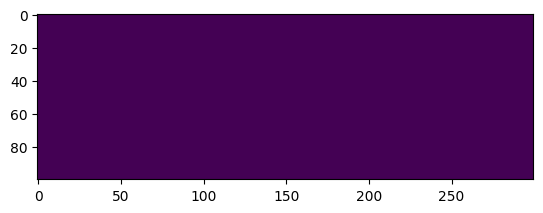

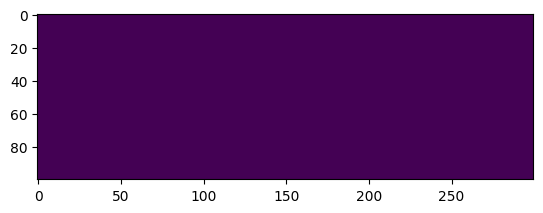

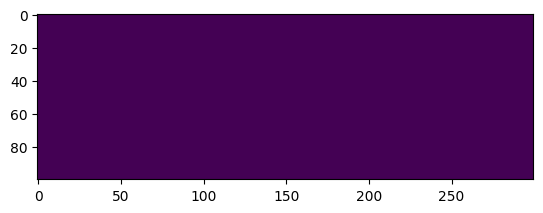

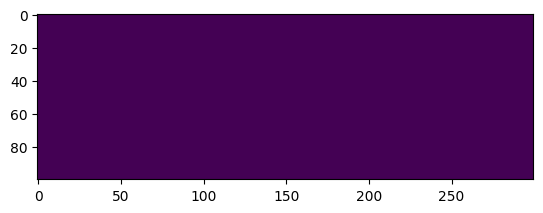

In [3]:
labels = torch.permute(tF.one_hot(slice, num_classes=num_classes), (2, 0, 1))

randperm = torch.randperm(labels.shape[0])
labels = labels[randperm, :, :]

plt.imshow(labels.argmax(dim=0), interpolation='nearest')
plt.show()

for c in range(labels.shape[0]):
    plt.imshow(labels[c], interpolation='nearest')
    plt.show()

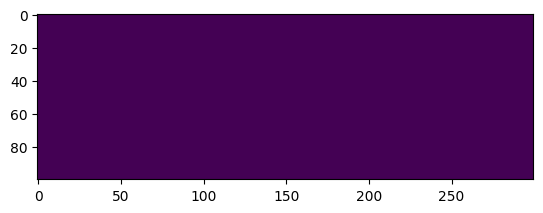

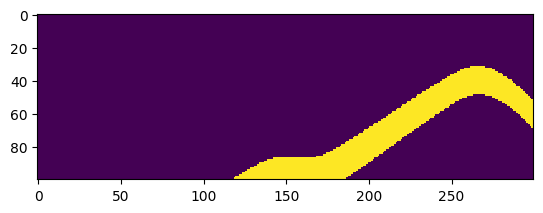

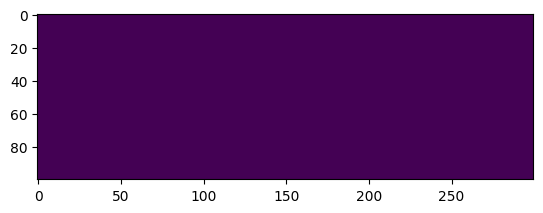

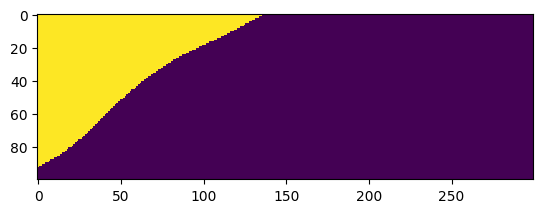

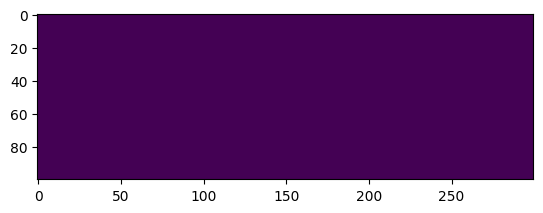

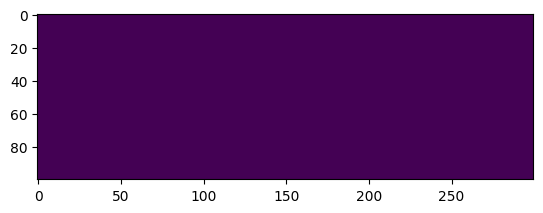

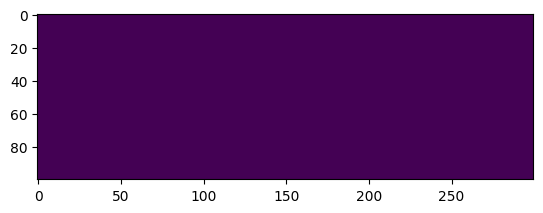

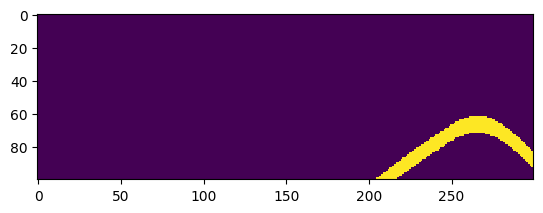

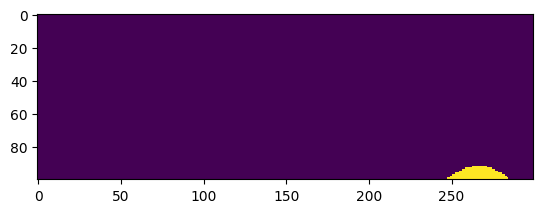

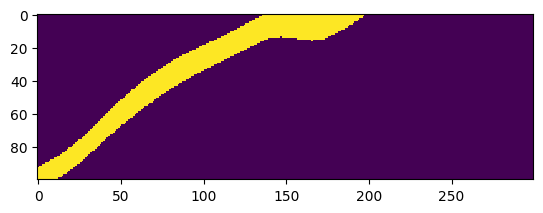

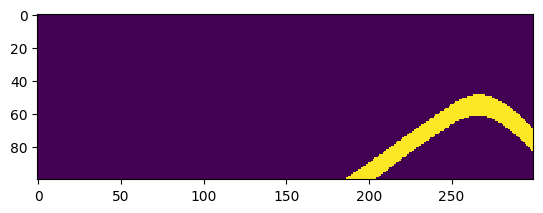

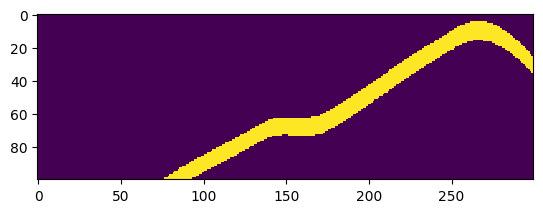

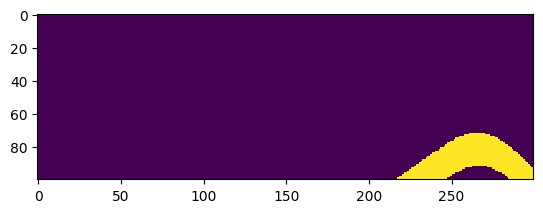

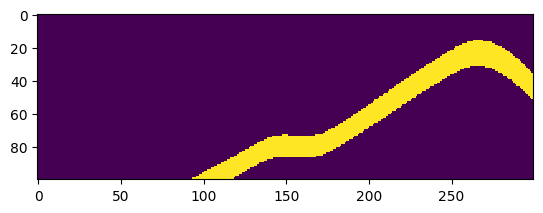

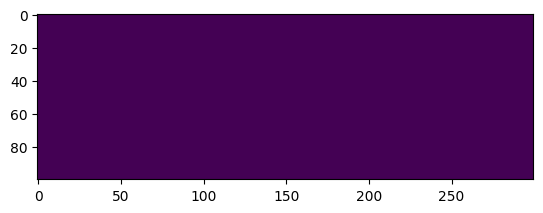

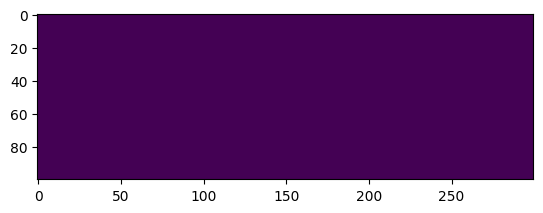

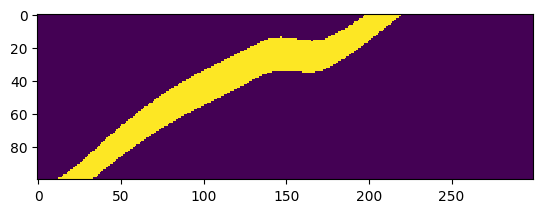

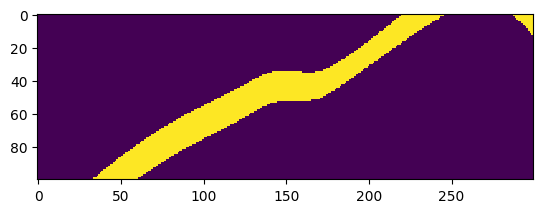

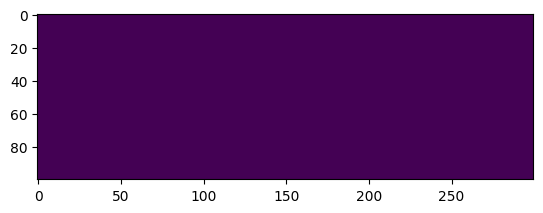

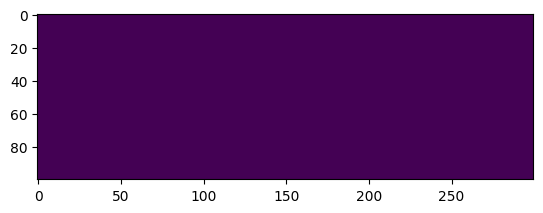

In [4]:
randperm = torch.randperm(labels.shape[0])
outputs = labels[randperm, :, :]

for c in range(outputs.shape[0]):
    if outputs[c].sum() != 0:
        outputs[c] = torch.zeros((outputs.shape[1], outputs.shape[2]))
        break

for c in range(outputs.shape[0]):
    plt.imshow(outputs[c], interpolation='nearest')
    plt.show()

In [5]:
flatten_labels = torch.flatten(labels, start_dim=1, end_dim=2) 
flatten_outputs = torch.flatten(outputs, start_dim=1, end_dim=2) 

def dice(labels, outputs):
    labels = torch.from_numpy(labels).to(dtype=torch.int64)
    outputs = torch.from_numpy(outputs).to(dtype=torch.int64)
    return tmF.dice(labels, outputs)

distances = pairwise_distances(flatten_labels, flatten_outputs, metric=dice)
distances = torch.from_numpy(distances)

In [6]:
labels_sum = flatten_labels.sum(dim=1)
labels_indexes = [i for i, v in enumerate(labels_sum.tolist()) if v != 0]

outputs_sum = flatten_outputs.sum(dim=1)
outputs_indexes = [i for i, v in enumerate(outputs_sum.tolist()) if v != 0]

In [7]:
indexes_reordered = []

for index in labels_indexes:
    is_matched = False
    distance = distances[index]
    
    while not is_matched:
        distance_argmax = distance.argmax().item()
        max_row = distance.max().item()
        max_col = distances[:, distance_argmax].max().item()
        is_empty = flatten_outputs[distance_argmax].sum().item() == 0

        if (max_row == max_col or is_empty) and distance_argmax not in indexes_reordered:
            is_matched = True
            indexes_reordered.append(distance_argmax)
        else:
            is_matched = False
            distances[distance_argmax] = 0
            
labels_indexes, indexes_reordered

([0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [10, 17, 1, 8, 16, 13, 7, 0, 3, 12, 9, 11])

In [8]:
indexes_reordered += [i for i in range(num_classes) if i not in indexes_reordered]

In [9]:
indexes_reordered

[10, 17, 1, 8, 16, 13, 7, 0, 3, 12, 9, 11, 2, 4, 5, 6, 14, 15, 18, 19]

BEFORE:


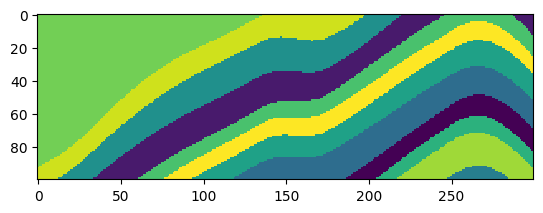

AFTER:


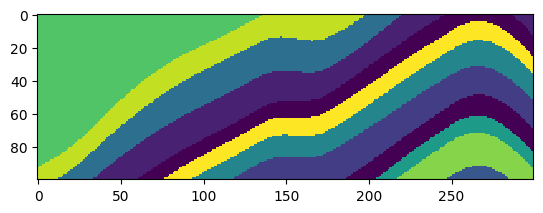

In [10]:
print('BEFORE:')
plt.imshow(labels.argmax(dim=0), interpolation='nearest')
plt.show()

print('AFTER:')
plt.imshow(outputs[indexes_reordered].argmax(dim=0), interpolation='nearest')
plt.show()